# Retail Analytics & Return Prediction
I merged customer/product/store/sale tables into one analytical dataset, produced revenue and returns insights, and trained a baseline model to predict returns.

In [20]:
import pandas as pd

Data sources: customers, products, sales, stores

In [21]:
customers = pd.read_csv("customer_data.csv")
products = pd.read_csv("product_data.csv")
sales = pd.read_csv("sales_data.csv")
store = pd.read_csv("store_data.csv")


Primary key uniqueness verification

In [22]:
# Verify primary key uniqueness
pk_checks = {
    "customers.customer_id": customers["customer_id"].is_unique,
    "products.product_id": products["product_id"].is_unique,
    "stores.store_id": store["store_id"].is_unique
}

pk_checks


{'customers.customer_id': True,
 'products.product_id': True,
 'stores.store_id': True}

In [23]:
# Inspect schemas before merging
schemas = {
    "sales": sales.dtypes,
    "customers": customers.dtypes,
    "stores": store.dtypes,
    "products": products.dtypes
}

schemas


{'sales': transaction_id     object
 date               object
 product_id         object
 store_id           object
 customer_id        object
 quantity            int64
 discount          float64
 returned            int64
 dtype: object,
 'customers': customer_id    object
 age             int64
 gender         object
 city           object
 email          object
 dtype: object,
 'stores': store_id         object
 store_name       object
 region           object
 store_size_m2     int64
 dtype: object,
 'products': product_id     object
 category       object
 color          object
 size           object
 season         object
 supplier       object
 cost_price    float64
 list_price    float64
 dtype: object}

## Data Integration
Sales data was filled with customer, product, and store attributes using left joins.


In [24]:
# Merge sales with customers
df = pd.merge(sales, customers, how='left', left_on='customer_id', right_on='customer_id') 

# Merge with products
df1 = pd.merge(df, products, how='left', left_on='product_id', right_on='product_id') 

# Merge with store
data = pd.merge(df1, store, how='left', left_on='store_id', right_on='store_id') 

# Check result
data.shape 

(50000, 22)

In [25]:
data.head(10)

,transaction_id,date,product_id,store_id,customer_id,quantity,discount,returned,age,gender,...,category,color,size,season,supplier,cost_price,list_price,store_name,region,store_size_m2
0,T0000001,2023-08-02,P004681,S004,C010043,3,0.0,0,50.0,Male,...,Shoes,NaN,S,Summer,suppliera,8.63,168.10,Online,Online,950.0
1,T0000002,2020-08-16,P006662,S003,C022472,1,0.0,0,22.0,Other,...,Accessories,Blue,M,Winter,supplierb,71.93,121.79,Faro Outlet,Algarve,336.0
2,T0000003,2020-02-21,P043402,S005,C016135,4,0.0,0,19.0,Other,...,Shoes,Red,L,Spring,suppliera,78.59,83.97,Coimbra Boutique,Coimbra,238.0
3,T0000004,2024-02-27,P029875,S003,C005605,3,NaN,1,69.0,Male,...,Shoes,Blue,L,Winter,supplierd,28.10,136.73,Faro Outlet,Algarve,336.0
4,T0000005,2021-07-17,P002476,S003,C005857,4,0.0,0,33.0,Other,...,Tops,Blue,M,Fall,supplierd,65.12,23.31,Faro Outlet,Algarve,336.0
5,T0000006,2021-05-16,P029990,S005,C008363,3,0.1,0,47.0,Other,...,Accessories,White,XL,Winter,supplierb,38.07,16.02,Coimbra Boutique,Coimbra,238.0
6,T0000007,2021-04-02,P012742,S004,C009301,4,0.0,0,46.0,Male,...,Bottoms,Yellow,M,Spring,supplierd,17.47,60.73,Online,Online,950.0
7,T0000008,2020-10-12,P013477,S003,C000971,1,0.2,0,55.0,Male,...,Accessories,Green,M,Fall,supplierb,56.87,66.18,Faro Outlet,Algarve,336.0
8,T0000009,2024-02-17,P009924,S004,C009786,1,0.0,0,26.0,Male,...,Tops,Blue,M,Winter,supplierd,29.89,113.28,Online,Online,950.0
9,T0000010,2020-07-28,P017086,S002,C013109,4,0.0,1,47.0,Male,...,Dresses,Blue,L,Summer,supplierd,69.94,40.49,Porto Center,Porto,728.0


## Data Quality Checks
Basic validity checks were applied to ensure quantities and prices were non-negative and pricing logic was reasonable.
Some transactions were sold below cost price. These cases were retained, as they may reflect promotions, clearance sales, or data quality issues and are relevant for business analysis.


In [26]:
# Fix date type
data["date"] = pd.to_datetime(data["date"])

# Validity checks (do not print huge tables)
neg_qty = (data["quantity"] <= 0).sum()
neg_cost = (data["cost_price"] <= 0).sum()
neg_list = (data["list_price"] <= 0).sum()
loss_count = (data["list_price"] < data["cost_price"]).sum()

neg_qty, neg_cost, neg_list, loss_count


(np.int64(0), np.int64(0), np.int64(0), np.int64(8628))

## Feature Engineering: Revenue and Profit

Missing discount values were treated as zero.  
Missing customer attributes and cost prices were preserved to avoid losing transactions.  
Revenue was computed independently of cost price, while profit analysis excluded rows with missing cost.


In [27]:
# Handle missing discounts
data["discount"] = data["discount"].fillna(0)

# Revenue calculation
data["revenue"] = data["quantity"] * data["list_price"] * (1 - data["discount"])

# Profit calculation (NaN where cost_price is missing)
data["profit"] = data["revenue"] - (data["cost_price"] * data["quantity"])


## Revenue Analysis
Revenue was aggregated across stores, products, customers, and regions to identify key revenue drivers.


In [28]:
# Revenue by store
store_revenue = (
    data.groupby("store_id", as_index=False)
    .agg(total_revenue=("revenue", "sum"))
)

# Revenue by product
product_revenue = (
    data.groupby("product_id", as_index=False)
    .agg(total_revenue=("revenue", "sum"))
)

# Revenue by customer
customer_revenue = (
    data.groupby("customer_id", as_index=False)
    .agg(total_revenue=("revenue", "sum"))
)

# Revenue by region
region_revenue = (
    data.groupby("region", as_index=False)
    .agg(total_revenue=("revenue", "sum"))
)


In [29]:
store_revenue = store_revenue.sort_values("total_revenue", ascending=False)
product_revenue = product_revenue.sort_values("total_revenue", ascending=False)
customer_revenue = customer_revenue.sort_values("total_revenue", ascending=False)
region_revenue = region_revenue.sort_values("total_revenue", ascending=False)


## Customer Revenue Concentration (Top 10%)

Customers were ranked by total revenue. The top 10% were compared to total revenue to measure revenue concentration.

**Result:** Top 10% of customers generate **25%** of total revenue, suggesting a relatively balanced distribution (no heavy dependence on a small customer group).


In [30]:
# Ensure customer_revenue is sorted descending first
customer_revenue = customer_revenue.sort_values("total_revenue", ascending=False).reset_index(drop=True)

top_10_percent_count = int(len(customer_revenue) * 0.10)
top_10_customers = customer_revenue.head(top_10_percent_count)

top_10_revenue = top_10_customers["total_revenue"].sum()
total_revenue = customer_revenue["total_revenue"].sum()

revenue_share = top_10_revenue / total_revenue * 100
revenue_share


np.float64(25.696717569367067)

## Store Preference of Top Customers

Transactions from the top 10% revenue-generating customers were analyzed to identify which stores they purchase from most.


In [31]:
# Keep only customer_id for filtering
top_10_customer_ids = top_10_customers[["customer_id"]]

# Transactions made by top customers only
top_customer_transactions = data.merge(
    top_10_customer_ids,
    on="customer_id",
    how="inner"
)


In [32]:
top_customer_stores = (
    top_customer_transactions
    .groupby("store_id", as_index=False)
    .agg(
        total_revenue=("revenue", "sum"),
        transactions=("transaction_id", "count")
    )
    .sort_values("total_revenue", ascending=False)
    .reset_index(drop=True)
)

from IPython.display import display

display(top_customer_stores.head(20))



,store_id,total_revenue,transactions
0,S005,623806.621,1799
1,S001,622776.302,1843
2,S004,611882.137,1780
3,S003,608908.973,1727
4,S002,590709.016,1711
5,S999,13074.469,33


Top customers generate similar revenue across most stores, indicating balanced store performance, with one minor store showing significantly lower contribution.


## Product Return Rate Analysis

Product-level return rates were calculated as the proportion of returned transactions.
To avoid misleading results from low-volume products, the analysis was restricted to products with at least 20 transactions.


In [33]:
return_prod = (
    data.groupby("product_id", as_index=False)
    .agg(
        return_rate=("returned", "mean"),
        transactions=("transaction_id", "count")
    )
)
return_prod_filtered = return_prod[return_prod["transactions"] >= 20]


**Example insight:**  
Product **P999999** shows a return rate of **13%** across **200 transactions**, indicating a moderately high likelihood of return compared to typical retail benchmarks.


## Machine Learning: Return Prediction

A baseline classification model was built to predict whether a transaction would be returned.


In [34]:
# Select features and target
ml_features = ["quantity", "discount", "store_id", "list_price", "category", "season", "returned"]
ml_data = data[ml_features]

# Remove rows with missing values (low proportion)
ml_data = ml_data.dropna()

# Remove duplicate rows
ml_data = ml_data.drop_duplicates()

# Split features and target
X = ml_data.drop(columns="returned")
y = ml_data["returned"]

# Encode categorical variables
X = pd.get_dummies(X, columns=["store_id", "category", "season"], dtype=int)

# Check class balance
y.value_counts(normalize=True)


returned
0    0.89997
1    0.10003
Name: proportion, dtype: float64

The target variable is highly imbalanced, with returned transactions representing a minority of observations.  
Model evaluation therefore focuses on recall for the returned class.


In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

# Train model
model = RandomForestClassifier(
    random_state=42,
    n_estimators=250,
    max_depth=10,
    class_weight="balanced"
)

model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
accuracy_train = accuracy_score(y_train, model.predict(X_train))
accuracy_test = accuracy_score(y_test, y_pred)
recall_returned = recall_score(y_test, y_pred, pos_label=1)

accuracy_train, accuracy_test, recall_returned


(0.8301968144465862, 0.7600689865070508, 0.18052738336713997)

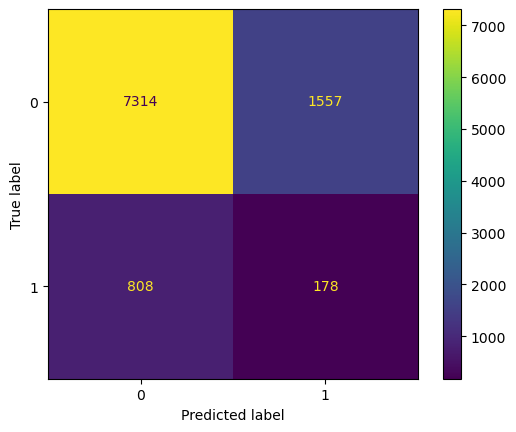

In [36]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()


Although class weighting was applied, the model achieved low recall for returned transactions.
This suggests that return behavior cannot be reliably predicted using transactional features alone.
Improving performance would likely require additional data such as customer history,
product quality indicators, or post-purchase feedback.
